
# <span style="color:rgb(213,80,0)">Comparison between coupled and uncoupled thermal simulation</span>

To compute the thermal response of a battery cell, one can either run a fully coupled simulation or run first an isothermal simulation and then use the output to compute the thermal response in a thermal\-only simulation.


In the second case, we do not get any feedback from the thermal model to the electrochemical model.


In this example, we compare the solutions obtained both for the voltage and for the temperature on a P4D model.

## setup material property input

We use a lithium\-ion battery cell with NMC cathode and graphite anode


In [1]:
jsonfilename = fullfile('ParameterData'        , ...
                        'BatteryCellParameters', ...
                        'LithiumIonBatteryCell', ...
                        'lithium_ion_battery_nmc_graphite.json');
jsonstruct_material = parseBattmoJson(jsonfilename);

## Setup geometry input

We use a simple 3d\-geometry (see image below) with only one layer


In [2]:
jsonfilename = fullfile('Examples'     , ...
                        'JsonDataFiles', ...
                        'geometry3d.json');
jsonstruct_geometry = parseBattmoJson(jsonfilename);

## Setup Control input

We use a single discharge scenario


In [3]:
jsonfilename = fullfile('Examples', 'JsonDataFiles', 'cc_discharge_control.json');
jsonstruct_control = parseBattmoJson(jsonfilename);


We merge the structures into a single input structure


In [4]:
jsonstruct = mergeJsonStructs({jsonstruct_geometry , ...
                               jsonstruct_material , ...
                               jsonstruct_control}, 'warn', false);

## Modify input structure

We modify the input parameters manually to obtain higher temperature increases so that the difference between the two simulation approaches get enhanced.


We change the heat transfer coefficient to low values


In [5]:
jsonstruct.ThermalModel.externalHeatTransferCoefficientTab = 1e-1;
jsonstruct.ThermalModel.externalHeatTransferCoefficient    = 1e-1;


We reduce by a constant factor the specific heat capacities of all the materials


In [6]:
coef = 5e-2;
locations = {{'NegativeElectrode', 'CurrentCollector', 'specificHeatCapacity'}, ...
             {'NegativeElectrode', 'Coating', 'ActiveMaterial', 'specificHeatCapacity'}, ...
             {'PositiveElectrode', 'CurrentCollector', 'specificHeatCapacity'}, ...
             {'PositiveElectrode', 'Coating', 'ActiveMaterial', 'specificHeatCapacity'}, ...
             {'Electrolyte', 'specificHeatCapacity'}};

for iloc = 1 : numel(locations)
    loc = locations{iloc};
    val = getJsonStructField(jsonstruct, loc);
    jsonstruct = setJsonStructField(jsonstruct, loc, coef*val, 'handleMisMatch', 'quiet');
end


We chane the lower cutoff voltage


In [7]:
jsonstruct.Control.lowerCutoffVoltage = 3.6;

## Run thermal simulation

In [8]:
output_fullycoupled = runBatteryJson(jsonstruct);

## Grid mesh

Now the model is setup, we can plot the grid



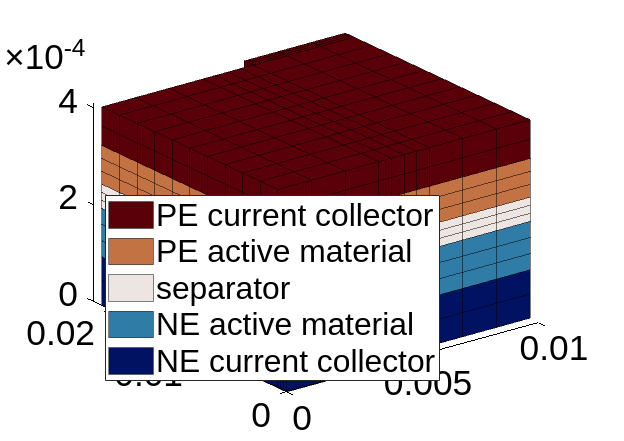

In [9]:
plotBatteryGrid(output_fullycoupled.model, 'shortLegendText', true, 'figure', 1);

## Run iso\-thermal simulation

We modify the input structure and switch to non\-thermal


In [10]:
jsonstruct_isothermal = setJsonStructField(jsonstruct, 'use_thermal', false, 'handleMisMatch', 'quiet');


We run the iso\-thermal simulation


In [11]:
output_isothermal = runBatteryJson(jsonstruct_isothermal);

## Setup thermal\-only simulation

We compute the source terms from the output states obtained from the isothermal simulation. The source terms depends on the norm of the charge and mass fluxes and on the reaction rates.


In [12]:
states = output_isothermal.states;
for istate = 1 : numel(states)
    % The functions to compute the source terms are available in the fully coupled model.
    states{istate} = output_fullycoupled.model.evalVarName(states{istate}, {'ThermalModel', 'jHeatSource'});
end

## Setup source term

We use the values of thermal source that we just computed to setup an helper structure which is going to used to send the heat source to the thermal\-only simulation


In [13]:
sourceTerms = cellfun(@(state) state.ThermalModel.jHeatSource, states, 'uniformoutput', false);

hss = HeatSourceSetup(sourceTerms, output_isothermal.time);

## Setup thermal\-only model

The thermal\-only model uses the same code as the thermal component model used in the fully coupled simulation


In [14]:
inputparams_thermal = output_fullycoupled.inputparams.ThermalModel;


The effective thermal properties depends on the intrinsic thermal property of each of the constituant of the battery. The effective thermal properties are setup when the fully\-coupled model is instantiated. We recover those property to use them for the thermal\-only model


In [15]:
inputparams_thermal.effectiveThermalConductivity    = output_fullycoupled.model.ThermalModel.effectiveThermalConductivity;
inputparams_thermal.effectiveVolumetricHeatCapacity = output_fullycoupled.model.ThermalModel.effectiveVolumetricHeatCapacity;

model_thermal = ThermalComponent(inputparams_thermal);


The thermal model is used as the main simulation model. We equip it for simulation (setup the necessary structures)


In [16]:
model_thermal.isRootSimulationModel = true;
model_thermal = model_thermal.equipModelForComputation();

## Setup the simulation schedule

The simulation schedule contains also the heat source term, which is an external source seen from the thermal\-only model.


We use the same time steps as the iso\-thermal simulation.


In [17]:
times = hss.times;

clear step
step.val     = [times(1); diff(times)];
step.control = ones(numel(times), 1);

clear control
control.src = @(time) hss.eval(time);

schedule = struct('control', control, ...
                  'step'   , step);

## setup initial state

The initial state is a constant temperature. For convenience, we just retrieve it from the fully\-coupled simulation


In [18]:
initstate = output_fullycoupled.model.setupInitialState(jsonstruct);

clear state0;
state0.T = initstate.ThermalModel.T;

## run thermal\-only simulation

In [19]:
simInput = struct('model'    , model_thermal, ...
                  'initstate', state0, ...
                  'schedule' , schedule);

simsetup = SimulationSetup(simInput);

states_thermal = simsetup.run();

## Plotting

We plot the evolution of the maximum temperature for the full\-coupled and thermal\-only simulations and the discharge voltage curves between the iso\-thermal and fully\-coupled simulations.



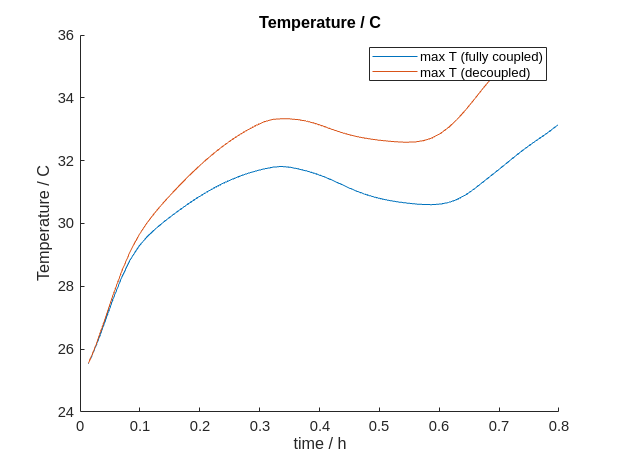

In [20]:
T0 = PhysicalConstants.absoluteTemperature;

time   = output_fullycoupled.time;
E      = output_fullycoupled.E;
states = output_fullycoupled.states;

Tmax = cellfun(@(state) max(state.ThermalModel.T + T0), states);

figure(2)
hold on
plot(time / hour, Tmax, 'displayname', 'max T (fully coupled)');
title('Temperature / C')
xlabel('time / h');
ylabel('Temperature / C');

figure(3)
hold on
plot(time/hour, E, 'displayname', 'fully coupled')
title('Voltage / V');
xlabel('time / h');
ylabel('voltage / V');

states = states_thermal;

time = cellfun(@(state) state.time, output_isothermal.states);
E    = cellfun(@(state) state.Control.E, output_isothermal.states);
Tmin = cellfun(@(state) min(state.T + T0), states);
Tmax = cellfun(@(state) max(state.T + T0), states);

figure(2)
plot(time / hour, Tmax, 'displayname', 'max T (decoupled)');
title('Temperature / C')
xlabel('time / h');
ylabel('Temperature / C');

legend show


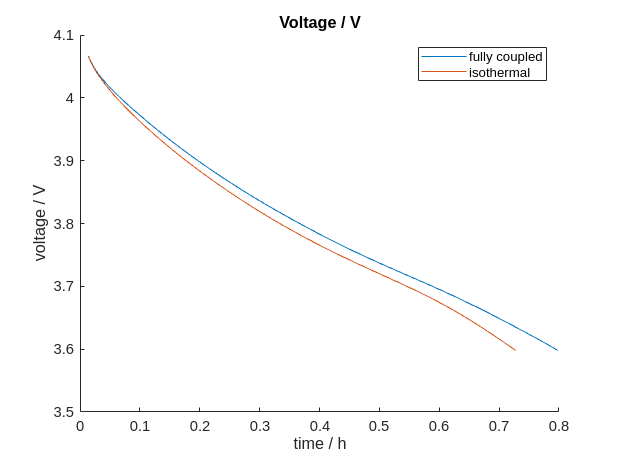

In [21]:

figure(3)
plot(time/hour, E, 'displayname', 'isothermal')
title('Voltage / V');
xlabel('time / h');
ylabel('voltage / V');

legend show